# **Preliminaries**

In [7]:
#import all the classes and stuff


In [8]:
!pip install QuantLib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#Constants
from enum import Enum

class Constants:
    r"""
    Static class for constants and global variables
    """

    # Global variables & constants
    MAX_STEPS = int(1e5)

    # Monte-Carlo pricing iterations
    MC_DEFAULT_ITERS = int(5e2)

    # Defining the available numerical schemes
    Scheme = Enum("Scheme", ["EULER", "MILSTEIN"])

    # Defining the available numerical schemes
    Contract = Enum("Contract", ["CALL", "PUT"])

    # Z-score for Monte-Carlo confidence intervals
    Z_SCORES = {
        80: 1.282,
        85: 1.440,
        90: 1.645,
        95: 1.960,
        99: 2.576,
        99.5: 2.807,
        99.9: 3.291
    }
    # Reference: https://www.alchemer.com/resources/blog/how-to-calculate-confidence-intervals/
    
    # Available Confidence interval levels
    AVAILABLE_CI_LEVELS = list(Z_SCORES.keys())

    # Enumeration of available levels
    Level = Enum("Level", dict((f"LEVEL_{str(k).replace('.', '_')}", k) for k in list(Z_SCORES.keys())))

# Importing all the libraries
import numpy as np
import numpy.random as npr
import time
import warnings
import scipy
import random
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import missingno as msn
import QuantLib as ql
from tqdm.notebook import trange, tqdm
from typing import List, Union

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

# Setting up a fixed random seed for experiment purposes
npr.seed(1)


class Utils:
    r"""
    Static class for utils functions
    """
    
    @staticmethod
    def get_level_values(x: List[Constants.Level]) -> Union[List[int], List[float], List[Union[int, float]]]:
        r"""Function returning the list of the CI level values
        Args:
            x (List[Constants.Level]): List of CI levels
        Returns:
            Union[List[int], List[float], List[Union[int, float]]]: List of level values
        """
        return [level.value for level in x]

    @staticmethod
    def cast_df(x: Union[dict, list, np.ndarray, pd.Series]) -> pd.DataFrame:
        r"""Function to explicitly cast a dictionary or Numpy array into a **pandas** `DataFrame`
        Args:
            x (dict | list | np.ndarray | pd.Series): Input data variable
        Returns:
            pd.DataFrame: Output Pandas `DataFrame`
        """
        return pd.DataFrame(x)

    @staticmethod
    def generate_correlated_gaussians(rho: float = 0.5,
                                      T: float = 1.0,
                                      N: int = Constants.MAX_STEPS,
                                      verbose: bool = False) -> np.ndarray:
        r"""Function which generates a series of two Gaussian series correlated by the given
        factor $\rho \in \left]-1, 1\right[$
        Args:
            rho (float, optional): Correlation ratio given by the user. Defaults to 0.5.
            T (float, optional): Time horizon (upper bound of the time interval). Defaults to 1.0.
            N (int, optional): Number of step in the time mesh. Defaults to Constants.MAX_STEPS.
            verbose (bool, optional): Boolean to verbose. Defaults to False.
        Returns:
            np.ndarray: 2 numpy arrays which corresponds to *Brownian increments* ($(dB_t)_t$ and $(dW_t)_t$)
        """            
        # Checking the value of rho
        assert rho < 1.0 and rho > -1.0
        
        # Creating the correlation matrix
        C = np.array([[1, rho], [rho, 1]])
        
        # Performing the Cholesky decomposition
        L = np.linalg.cholesky(C) # L is the lower triangular matrix, L.T is the upper triangular matrix
        
        # Setting up the time step
        dT = T/N
        
        # Creation of 2 Brownian motions with N steps
        X = np.random.normal(0, (dT**(1/2)), (2, N))
        
        # Compute the correlated paths
        CX = np.dot(L, X)
        
        # Checking the correlation ratio of the simulated BM
        if verbose:
            corr_coeff = np.corrcoef(CX.cumsum(axis=1))[1][0]
            print("-------------- Generation of Brownian Motions --------------")
            print(f"Simulated rho: {corr_coeff} \tGiven rho: {rho}\nAbsolute error: {np.abs(corr_coeff - rho)}")
            
        # Return the correlated paths
        return CX
    
    @staticmethod
    def generate_correlated_brownians(*args, **kwargs) -> np.ndarray:
        r"""Function which generates a series of two Brownian motions correlated by the given
        factor $\rho \in \left]-1, 1\right[$
        Returns:
            np.ndarray: 2 numpy arrays which corresponds to *Brownian increments* ($(dB_t)_t$ and $(dW_t)_t$)
        """
        # Computing the Gaussian increments
        CX = Utils.generate_correlated_gaussians(*args, **kwargs)
        return [path.cumsum() for path in CX]
    
    @staticmethod
    def generate_ndim_correlated_gaussians(mu: np.ndarray,
                                           sigma: np.ndarray, 
                                           T: float = 1.0, 
                                           N: int = Constants.MAX_STEPS, 
                                           verbose: bool = False) -> np.ndarray:
        r"""Function which generates a series of two Gaussian series correlated by the given
        vector of means : $\mu \in \mathbb{R}^n$ and correlation matrix $\Sigma \in \mathcal{S}_n$
        The underlying algorithm generates samples of increments from a correlated Brownian motion with a given mean $\mu$ and Variance-Covariance matrix $\Sigma$.
        
        The algorithm uses the fact that if you have $n$ independent brownian motions, the samples given by $\mu + C\times Z$ are distributed as $\mathcal{N}(\mu,\Sigma)$, where:
        
        - $Z \sim \mathcal{N}(0, 1)$ *(Gaussian variate)*
        - $\mu$ is the vector of means
        - $C$ is the square root of the Variance-Covariance matrix.
        $$C = \Sigma^{\frac{1}{2}}$$
        To compute the square root of the variance-covariance matrix $C$, the **Cholesky decomposition** is implemented.
        Args:
            mu (np.ndarray): Vector of means given by the user
            sigma (np.ndarray): Correlation matrix given by the user
            T (float, optional): Time horizon (upper bound of the time interval). Defaults to 1.0.
            N (int, optional): Number of step in the time mesh. Defaults to Constants.MAX_STEPS.
            verbose (bool, optional): Boolean to verbose. Defaults to False.
        Returns:
            np.ndarray: $n \in \mathbb{N}^+$ numpy arrays which corresponds to *Brownian increments* ($(dW^1_t)_t, \ldots, (dW^n_t)_t$)
        """
        pass

class Model:
    r""" Abstract class for models """
    pass

class Scenario:
    r"""Static function defining and declaring several scenarios for the $t \longmapsto \theta(t)$ values
    """
    
    @staticmethod
    def scenario_1(t: float):
        """Function defining the scenario 1
        Args:
            t (float): Time
        """        
        pass


class Pricer:
    r"""Abstract class for pricers """
    pass

    @staticmethod
    def CALL_PAYOFF(x: float, K: float) -> float:
        r"""Payoff function for a call option
        $$\Pi^{\text{CALL}} := (X - K)_+$$
        Args:
            x (float): underlying price
            K (float): Strike (Exercise price)
        Returns:
            float: Call payoff
        """        
        return max(0, x - K)
    
    @staticmethod
    def PUT_PAYOFF(x: float, K: float) -> float:
        r"""Payoff function for a put option
        $$\Pi^{\text{PUT}} := (K - X)_+$$
        Args:
            x (float): underlying price
            K (float): Strike (Exercise price)
        Returns:
            float: Put payoff
        """  
        return max(0, K - x)

class RatesModel(Model):
    r""" Abstract class for Interest rates models """
    pass

In [10]:
import numpy as np

class Vasicek(RatesModel):
    r"""Class representing the Vasicek model 
    
    $$
        \left\{
        \begin{aligned}
            \mathrm{d}r_t &= \kappa(\theta - r_t)\mathrm{d}t + \eta \mathrm{d}B_t \\
            r(0) &= r_0
        \end{aligned}
        \right.
    $$
    """
    
    # Name of the model
    MODEL_NAME = "VASICEK"
    
    def __init__(self, r0: float, kappa: float, theta: float, eta: float) -> None:
        r"""Default constructor in order to verify the validity of the parameters, and store them
        Args:
            r0 (float): Initial value $r_0$ of the process $(r_t)_t$ at time $t = 0$
            kappa (float): Mean-reversion speed parameter $\kappa$s
            theta (float): Mean-reversion center parameter $\theta$
            eta (float): Volatility (constant) parameter $\eta$
        """
        # Verification
        assert r0 > 0 and kappa > 0 and theta > 0 and eta > 0
        
        # Storing variable
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.eta = eta
        
    def __repr__(self) -> str:
        r"""Hard string representation
        Returns:
            str: Output string
        """
        return f"Vasicek model {self.get_parameter_string(onLaTeX=False)})"
    
    def __str__(self) -> str:
        r"""
        Gentle string representation
        Returns:
            str: Output string
        """
        return f"Vasicek model {self.get_parameter_string(onLaTeX=False)}"
  
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        r""" Function returning a user-friendly string displaying the model parameters values
        Args:
            onLaTeX (bool, optional): Boolean value indicating if $\LaTeX$ formatting is enabled. Defaults to True.
        Returns:
            str: Output string of each parameter's value
        """ 
        if onLaTeX:
            return f"($r_0$ = {self.r0}, $\kappa$ = {self.kappa}, $\\theta$ = {self.theta}, $\eta$ = {self.eta})"
        return f"(r0 = {self.r0}, kappa = {self.kappa}, theta = {self.theta}, eta = {self.eta})"

    def simulate_path(self, scheme: Constants.Scheme = Constants.Scheme.EULER, **kwargs) -> dict:
        r"""Function wrapping the 2 available simulators to simulate 1 path
        Args:
            scheme (Constants.Scheme, optional): Numerical scheme to be used. Defaults to Constants.Scheme.EULER.
        Returns:
            dict: Hashmap of results with keys `t` for time interval and `r` for rates simulation results
        """
        if scheme == Constants.Scheme.EULER:
            return self.simulate_euler(**kwargs)
        return self.simulate_milstein(**kwargs)
    
    def simulate_paths(self, M: int = 3, scheme: Constants.Scheme = Constants.Scheme.EULER, **kwargs) -> dict:
        r"""Function wrapping the 2 available simulators to simulate **several** paths
        Args:
            M (int, optional): Number of trajectories to be applied. Defaults to 3.
            scheme (Constants.Scheme, optional): Numerical scheme to be applied. Defaults to Constants.Scheme.EULER.
        Returns:
            dict: Hashmap of results with keys `t` for time interval and `r`$\star$ for rates simulation results where $\star$ stand for the id of the simulations
        """        
        assert M >= 1 and type(M) == int
        
        res = []
        for m in range(1, M + 1):
            if scheme == Constants.Scheme.EULER:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
            elif scheme == Constants.Scheme.MILSTEIN:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
        return res
            
    def simulate_euler(self,
                       T: float = 1.0,
                       N: int = Constants.MAX_STEPS,
                       dB: np.ndarray = None) -> dict:
        r"""Function implementing a path simulator following Vasicek model dynamics using the Euler-Maruyama method
        Args:
            T (float, optional): Time horizon. Defaults to 1.0.
            N (int, optional): Number of time step in the mesh. Defaults to Constants.MAX_STEPS.
            dB (np.ndarray, optional): Series of the Brownian increments. Defaults to None.
        Returns:
            dict: Dictionary (hashmap) with the time and generated rates columns
        """        
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dB array
        if dB is None:
            dB = np.random.normal(0, 1, N)

        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            r[t + 1] = r[t] + self.kappa*(self.theta - r[t])*dT + self.eta*dB[t]
        return {"t": H, "r":r}
        
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = Constants.MAX_STEPS,
                          dB: np.ndarray = None) -> dict:
        r"""Function implementing a path simulator following Vasicek model dynamics using the Milstein method
        Args:
            T (float, optional): Time horizon. Defaults to 1.0.
            N (int, optional): Number of time step in the mesh. Defaults to Constants.MAX_STEPS.
            dB (np.ndarray, optional): Series of the Brownian increments. Defaults to None.
        Returns:
            dict: Dictionary (hashmap) with the time and generated rates columns
        !!! note
            Since $b'(.) = 0$, the Milstein scheme is equivalent to the Euler scheme
        """   
        # Since b'(.) = 0, the Milstein scheme is equivalent to the Euler scheme
        return self.simulate_euler(T, N, dB=dB)

class HullWhite(RatesModel):
    r""" Class representing the Hull & White model
    
    $$
        \left\{
        \begin{aligned}
            \mathrm{d}r_t &= \kappa(\theta(t) - ar_t)\mathrm{d}t + \sigma\sqrt{r_t} \mathrm{d}B_t \\
            r(0) &= r_0
        \end{aligned}
        \right.
    $$
    """
        
    # Name of the model
    MODEL_NAME = "HULL-WHITE"
    
    def __init__(self, r0: float, a: float, sigma: float) -> None:
        r"""Default constructor in order to verify the validity of the parameters, and store them
        Args:
            r0 (float): Initial value $r_0$ of the process $(r_t)_t$ at time $t = 0$
            a (float): Mean-reversion center parameter $a$
            sigma (float): Volatility (constant) parameter $\sigma$
        """   
        # Verification
        assert r0 > 0 and a > 0 and sigma > 0
        
        # Storing variables
        self.r0 = r0
        self.a = a
        self.sigma = sigma
    
    def __repr__(self) -> str:
        r"""Hard string representation
        Returns:
            str: Output string
        """
        return f"Hull & White model {self.get_parameter_string(onLaTeX=False)})"
    
    def __str__(self) -> str:
        r"""
        Gentle string representation
        Returns:
            str: Output string
        """
        return f"Hull & White model {self.get_parameter_string(onLaTeX=False)}"
    
    def compute_theta(self) -> np.ndarray:
        r"""
        Function computing, storing and returning the theta 
        corresponding to the fitted interest rates term structure
        !!! danger
            **TODO**
        """
        # TODO
        pass
    
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        r""" Function returning a user-friendly string displaying the model parameters values
        Args:
            onLaTeX (bool, optional): Boolean value indicating if $\LaTeX$ formatting is enabled. Defaults to True.
        Returns:
            str: Output string of each parameter's value
        """
        if onLaTeX:
            return f"($r_0$ = {self.r0}, $a$ = {self.a}, $\sigma$ = {self.sigma})"
        return f"(r0 = {self.r0}, a = {self.a}, sigma = {self.sigma})"   

class EquityModel(Model):
    r""" Abstract class for Equity-Index models """
    pass

class Heston(EquityModel):
    r"""Class representing the Heston model *(stochastic volatility)*
    
    $$\frac{\mathrm{d}S_t}{S_t} := r_t\mathrm{d}t + \sqrt{V_t}\mathrm{d}W_t$$
    and
    $$\mathrm{d}V_t := \kappa(\theta - V_t)\mathrm{d}t + \eta\sqrt{V_t}\mathrm{d}\widetilde{W_t}$$
    """
    
    # Name of the model
    MODEL_NAME = "HESTON"
    pass

In [11]:
import pandas

class EuropeanPricer(Pricer):
    r"""Class representing a pricer of an European option 
    $$
    C^\text{EUR}(T, K) := \mathbb{E}\left[e^{-\int_0^T r_u \mathrm{~d} u}\left(S_T-K\right)_{+}\right]
    $$
    with maturity $T > 0$ and strike (exercise price) $K > 0$
    """
    
    def __init__(self, udl_model: EquityModel, preCompute: bool = False, N_MC: int = Constants.MC_DEFAULT_ITERS) -> None:
        r"""Construtor function retrieving and storing the underlying price model
        Args:
            udl_model (EquityModel): Underlying asset price model
            preCompute (bool, optional): Boolean value corresponding to the pre-computation of equity trajectories. Defaults to False.
            N_MC (int, optional): Number of Monte-Carlo trajectories to be considered. Defaults to Constants.MC_DEFAULT_ITERS.
        """
        self.preCompute : bool = preCompute
        self.isSimulated : bool  = False

        # Pricer parameter
        self.model: EquityModel = udl_model
        self.N_MC : int = N_MC
        
        # Pre-computing the equity trajectories
        if preCompute:
            print("Pre-computing the equity trajectories")
            self.simulate_samples(N_MC=N_MC)
    

    def simulate_samples(self, N_MC: int = Constants.MC_DEFAULT_ITERS) -> pandas.DataFrame: # trajectories to be stored (for caching)
        r"""Function which simulates prices trajectories
        Args:
            N_MC (int, optional): Number of Monte-Carlo trajectories to be simulated. Defaults to Constants.MC_DEFAULT_ITERS.
        Returns:
            pd.DataFrame: Trajectories
        """
        
        # Updating N_MC if different
        self.N_MC = N_MC


        # Simulating the trajectories necessary to Monte-Carlo
        trajectories = []
        R = trange(self.N_MC, colour="red", desc="Sim. progress")
        for i in R:
            R.set_description(f"Iteration #{i}/{N_MC}")
            trajectories.append(self.model.simulate_euler(getRates=True))

        # Casting it into pandas DataFrames for a better handling (using slicing)
        trajectories = [Utils.cast_df(k) for k in trajectories]

        # Storing the results
        self.trajectories = trajectories
        self.isSimulated = True

        # Returning the trajectories
        return self.trajectories


    def compute_option_price(self, K: float, 
                             contract: Constants.Contract = Constants.Contract.CALL,
                             ci_levels: Union[List[Constants.Level], Constants.Level] = Constants.Level.LEVEL_95) -> float:
        r"""Function computing and returning the option price thanks to a Monte-Carlo simulation, depending on its contract type
        $$
        \phi^i := \exp\Big(-\int_{0}^T r^i_u \mathrm{d}u\Big)\Pi(S^i_T, K)
        $$
        Args:
            K (float): Strike price (Exercise price)
            contract (Constants.Contract.CALL): Contract option type (PUT or CALL)
        Raises:
            Exception: Exception regarding the contract type
        Returns:
            float: Option price
        """        

        # If not simulated yet, we simulate the trajectories
        if not self.isSimulated:
            self.simulate_samples()

        # Defining the payoff function according to the contract type
        if contract == Constants.Contract.CALL:
            PAYOFF_FUNCTION = Pricer.CALL_PAYOFF 
        elif contract == Constants.Contract.PUT:
            PAYOFF_FUNCTION = Pricer.PUT_PAYOFF 
        else:
            raise Exception("The contract type is not valid.")

        # Retrieving the time interval values
        t = self.trajectories[0]["t"]

        # Retrieving the list of last-time underlying asset price $S^i_T$
        S_T_ = [self.trajectories[k]["S"].iloc[-1] for k in range(len(self.trajectories))]

        # Retrieving the list of rates $(r^i_t)_t$
        R_ = [self.trajectories[k]["r"].to_numpy() for k in range(len(self.trajectories))]

        # Computing the $\phi_i$
        PHIS = []
        for i in range(self.N_MC):
            # Computing the integral of interest rates using Simpson numerical method
            integral = scipy.integrate.simpson(R_[i], t)

            # Computing the coefficient $\phi_i$
            phi = np.exp(-integral)*PAYOFF_FUNCTION(x=S_T_[i], K=K)

            # Appending the $\phi_i$
            PHIS.append(phi)
        
        # Computing the option price by aggregating the previously-computed results
        OPTION_PRICE = (1/self.N_MC)*sum(PHIS)

        # Casting into a Numpy array to access statistic methods
        PHIS = np.array(PHIS)

        # Computing Monte-Carlo confidence intervals
        CI_LEVELS = []

        # Filtering with respect to the input type
        if type(ci_levels) == Constants.Level or (type(ci_levels) == list and len(ci_levels) == 1):
            if type(ci_levels) == list and len(ci_levels) == 1:
                CI_LEVELS.append(ci_levels[0])
            else:
                CI_LEVELS.append(ci_levels)
        elif type(ci_levels) == list:
            CI_LEVELS += ci_levels
        
        print(f"Required CI levels: ", Utils.get_level_values(CI_LEVELS))
        
        CI_DICT = {level.value: None for level in CI_LEVELS}
        # For each required CI level
        for level in CI_LEVELS:
            # Getting the respective Z-score
            a = Constants.Z_SCORES[level.value]
            
            # Computing the CI factor
            ci_factor = a*(PHIS.std())/np.sqrt(self.N_MC)

            # Computing the lower/upper bounds of the CI interval
            ci = {
                "lower": OPTION_PRICE - ci_factor, 
                "upper": OPTION_PRICE + ci_factor,
                "radius": ci_factor
            }
            CI_DICT[level.value] = ci

        # Returning the option price and the Confidence interval
        return {"price": OPTION_PRICE, "ci": CI_DICT}

    def compute_option_price_call(self, K: float, *args, **kwargs) -> float:
        r"""Function computing and returning the call option price thanks to a Monte-Carlo simulation
        Args:
            K (float): Strike price (Exercise price)
        Returns:
            float: Call option price
        """        
        return self.compute_option_price(K=K, contract=Constants.Contract.CALL, *args, **kwargs)

    def compute_option_price_put(self, K: float, *args, **kwargs) -> float:
        r"""Function computing and returning the put option price thanks to a Monte-Carlo simulation
        Args:
            K (float): Strike price (Exercise price)
        Returns:
            float: Put option price
        """       
        return self.compute_option_price(K=K, contract=Constants.Contract.PUT, *args, **kwargs)

class CIR(RatesModel):
    r""" Class representing the Cox-Ingersoll-Ross (CIR) model
    
    $$
    \left\{
    \begin{aligned}
        \mathrm{d}r_t &= \kappa(\theta - r_t)\mathrm{d}t + \sigma\sqrt{r_t} \mathrm{d}B_t \\
        r(0) &= r_0
    \end{aligned}
    \right.
    $$
    """

    # Name of the model
    MODEL_NAME = "CIR"
    
    def __init__(self, r0: float, kappa: float, theta: float, sigma: float) -> None:
        r"""Default constructor in order to verify the validity of the parameters, and store them
        Args:
            r0 (float): Initial value $r_0$ of the process $(r_t)_t$ at time $t = 0$
            kappa (float): Mean-reversion speed parameter $\kappa$s
            theta (float): Mean-reversion center parameter $\theta$
            sigma (float): Volatility (constant) parameter $\sigma$
        """        
        # Verification
        assert r0 > 0 and kappa > 0 and theta > 0 and sigma > 0
        
        # Verifying the Feller condition
        self.feller_condition = 2*kappa*theta >= sigma**2
        if self.feller_condition:
            print("(r_t)_t strictly positive")
        
        # Storing variables
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        
    def __repr__(self) -> str:
        r"""Hard string representation
        Returns:
            str: Output string
        """
        return f"CIR model {self.get_parameter_string(onLaTeX=False)})"
    
    def __str__(self) -> str:
        r"""
        Gentle string representation
        Returns:
            str: Output string
        """
        return f"CIR model {self.get_parameter_string(onLaTeX=False)}"
  
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        r""" Function returning a user-friendly string displaying the model parameters values
        Args:
            onLaTeX (bool, optional): Boolean value indicating if $\LaTeX$ formatting is enabled. Defaults to True.
        Returns:
            str: Output string of each parameter's value
        """
        if onLaTeX:
            return f"($r_0$ = {self.r0}, $\kappa$ = {self.kappa}, $\\theta$ = {self.theta}, $\sigma$ = {self.sigma})"
        return f"(r0 = {self.r0}, kappa = {self.kappa}, theta = {self.theta}, sigma = {self.sigma})"
    
    def simulate_path(self, scheme: Constants.Scheme = Constants.Scheme.EULER, **kwargs) -> dict:
        r"""Function wrapping the 2 available simulators to simulate 1 path
        Args:
            scheme (Constants.Scheme, optional): Numerical scheme to be used. Defaults to Constants.Scheme.EULER.
        Returns:
            dict: Hashmap of results with keys `t` for time interval and `r` for rates simulation results
        """
        if scheme == Constants.Scheme.EULER:
            return self.simulate_euler(**kwargs)
        return self.simulate_milstein(**kwargs)
    
    def simulate_paths(self, M: int = 3, scheme: Constants.Scheme = Constants.Scheme.EULER, **kwargs) -> dict:
        r"""Function wrapping the 2 available simulators to simulate **several** paths
        Args:
            M (int, optional): Number of trajectories to be applied. Defaults to 3.
            scheme (Constants.Scheme, optional): Numerical scheme to be applied. Defaults to Constants.Scheme.EULER.
        Returns:
            dict: Hashmap of results with keys `t` for time interval and `r`$\star$ for rates simulation results where $\star$ stand for the id of the simulations
        """ 
        assert M >= 1 and type(M) == int
        
        res = []
        for m in range(1, M + 1):
            if scheme == Constants.Scheme.EULER:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
            elif scheme == Constants.Scheme.MILSTEIN:
                sim = self.simulate_milstein(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
        return res
    
    def simulate_euler(self,
                       T: float = 1.0,
                       N: int = Constants.MAX_STEPS,
                       dB: np.ndarray = None) -> dict:
        r"""Function implementing a path simulator following CIR model dynamics using the Euler-Maruyama method
        Args:
            T (float, optional): Time horizon. Defaults to 1.0.
            N (int, optional): Number of time step in the mesh. Defaults to Constants.MAX_STEPS.
            dB (np.ndarray, optional): Series of the Brownian increments. Defaults to None.
        Returns:
            dict: Dictionary (hashmap) with the time and generated rates columns
        """ 
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dB array
        if dB is None:
            dB = np.random.normal(0, 1, N)

        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            #if r[t] <= 0:
            #    r[t] = np.abs(r[t])
            r[t + 1] = r[t] + self.kappa*(self.theta - r[t])*dT + self.sigma*np.sqrt(np.abs(r[t]))*dB[t]
        return {"t": H, "r": r}
        
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = Constants.MAX_STEPS,
                          dB: np.ndarray = None) -> dict:
        r"""Function implementing a path simulator following CIR model dynamics using the Euler-Maruyama method
        Args:
            T (float, optional): Time horizon. Defaults to 1.0.
            N (int, optional): Number of time step in the mesh. Defaults to Constants.MAX_STEPS.
            dB (np.ndarray, optional): Series of the Brownian increments. Defaults to None.
        Returns:
            dict: Dictionary (hashmap) with the time and generated rates columns
        !!! danger "Warning"
            Since $b'(.) \neq 0$, the Milstein scheme is not equivalent to the Euler scheme and a complete implementation is required !
        
        """ 
        
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dB array
        if dB is None:
            dB = np.random.normal(0, 1, N)

        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            #print(r[t])
            r[t + 1] = r[t] \
                     + self.kappa*(self.theta - r[t])*dT  \
                     + self.sigma*np.sqrt(np.abs(r[t]))*dB[t] \
                     + (1/2)*(dB[t]**2 - dT)*(self.sigma*np.sqrt(np.abs(r[t])))*(self.sigma)/(2*np.sqrt(np.abs(r[t])))
        return {"t": H, "r": r}
        
    def plot_feller_line(self, **kwards) -> None:    
        r"""
        Function printing the Feller line to highlight the positivity of simulated rates
        Returns:
            None
        """
        if self.feller_condition:
            plt.axhline(y=0, color="m", ls="-.", alpha=0.7, **kwards, label="Feller line")
            _ = plt.legend()


In [12]:
class BlackScholes(EquityModel):
    r""" Class representing the Black & Scholes model 
    
    $$\frac{\mathrm{d}S_t}{S_t} := r_t\mathrm{d}t + \sigma\mathrm{d}W_t$$
    """
    
    # Name of the model
    MODEL_NAME = "BLACK-SCHOLES"
    
    def __init__(self, S0: float, r: RatesModel, sigma: float, rho: float = 0.99) -> None:
        r"""Default constructor in order to verify the validity of the parameters, and store them
        Args:
            S0 (float): Initial value $S_0$ of the process $(S_t)_t$ at time $t = 0$
            r (RatesModel): Rate model to be used (corresponding to the $(r_t)_t$ process)
            sigma (float): Volatility (constant) parameter $\sigma \in \mathbb{R}^+$
            rho (float): Correlation coefficient $\rho$ for the generation of the two Brownian motion.
        Raises:
            Exception: Exception raided if wrong rate model
        """
        # Verification of parameters
        assert S0 > 0 and sigma > 0
        assert rho <= 1 and rho >= -1 # Boundaries for Brownian motions
        
        # Check if the rate model is a registered and valid model 
        if not issubclass(type(r), RatesModel): # type(r).__bases__[0] == RatesModel
            raise Exception("r must be a registered interest rates model\n(Available models: Vasicek, CIR, HW)")
                
        # Storing variables
        self.S0 = S0
        self.r: RatesModel = r
        self.sigma = sigma
        self.rho = rho

        self.LAST_SIMULATION = {}
        
    def __repr__(self) -> str:
        r"""Hard string representation
        Returns:
            str: Output string
        """
        return f"Black-Scholes model {self.get_parameter_string(onLaTeX=False)}"
    
    def __str__(self) -> str:
        r"""
        Gentle string representation
        Returns:
            str: Output string
        """
        return f"Black-Scholes model {self.get_parameter_string(onLaTeX=False)}"
  
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        r""" Function returning a user-friendly string displaying the model parameters values
        Args:
            onLaTeX (bool, optional): Boolean value indicating if $\LaTeX$ formatting is enabled. Defaults to True.
        Returns:
            str: Output string of each parameter's value
        """
        if onLaTeX:
            return f"($S_0$ = {self.S0}, $\sigma$ = {self.sigma})"
        return f"(S0 = {self.S0}, sigma = {self.sigma})"
    
    def simulate_path(self, scheme: Constants.Scheme = Constants.Scheme.EULER, **kwargs) -> dict:
        r"""Function wrapping the 2 available simulators to simulate 1 path
        Args:
            scheme (Constants.Scheme, optional): Numerical scheme to be used. Defaults to Constants.Scheme.EULER.
        Returns:
            dict: Hashmap of results with keys `t` for time interval and `r` for rates simulation results
        """
        if scheme == Constants.Scheme.EULER:
            return self.simulate_euler(**kwargs)
        return self.simulate_milstein(**kwargs)
    
    def simulate_paths(self, M: int = 3, scheme: Constants.Scheme = Constants.Scheme.EULER, **kwargs) -> dict:
        r"""Function wrapping the 2 available simulators to simulate **several** paths
        Args:
            M (int, optional): Number of trajectories to be applied. Defaults to 3.
            scheme (Constants.Scheme, optional): Numerical scheme to be applied. Defaults to Constants.Scheme.EULER.
        Returns:
            dict: Hashmap of results with keys `t` for time interval and `r`$\star$ for rates simulation results where $\star$ stand for the id of the simulations
        """
        assert M >= 1 and type(M) == int
        
        res = []
        for m in range(1, M + 1):
            if scheme == Constants.Scheme.EULER:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["S"])
            elif scheme == Constants.Scheme.MILSTEIN:
                sim = self.simulate_milstein(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["S"])
        return res
    
    def simulate_euler(self,
                       T: float = 1.0,
                       N: int = Constants.MAX_STEPS,
                       getRates: bool = False) -> dict:
        r"""Function implementing a path simulator following Black-Scholes model dynamics using the Euler-Maruyama method
        Args:
            T (float, optional): Time horizon. Defaults to 1.0.
            N (int, optional): Number of time step in the mesh. Defaults to Constants.MAX_STEPS.
            getRates (bool, optional): Add the corresponding simulated rates within the hashmap. Defaults to False.
        Returns:
            dict: Dictionary (hashmap) with the time and generated asset price columns
        """ 
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dW array
        dB, dW = Utils.generate_correlated_gaussians(rho=self.rho)

        # Initializing the rates array
        S = np.zeros(N)
        S[0] = self.S0
        
        # Simulating the interest rates according to the given model
        simulated_rates = self.r.simulate_euler(T=T, N=N, dB=dB)
        simulated_rates = simulated_rates["r"]

        # Computing the rates
        for t in range(N - 1):
            S[t + 1] = S[t] + (simulated_rates[t]*S[t])*dT + self.sigma*S[t]*dW[t]
        
        # Check for right output
        if getRates:
            return {"t": H, "S": S, "r": simulated_rates}
        return {"t": H, "S": S}
        
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = Constants.MAX_STEPS,
                          getRates: bool = False) -> dict:
        r"""Function implementing a path simulator following Black-Scholes model dynamics using the Milstein method
        Args:
            T (float, optional): Time horizon. Defaults to 1.0.
            N (int, optional): Number of time step in the mesh. Defaults to Constants.MAX_STEPS.
            getRates (bool, optional): Add the corresponding simulated rates within the hashmap. Defaults to False.
        Returns:
            dict: Dictionary (hashmap) with the time and generated asset price columns
        !!! danger "Warning"
            Since $b'(.) \neq 0$, the Milstein scheme is not equivalent to the Euler scheme and a complete implementation is required !
        """ 
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dW array
        dB, dW = Utils.generate_correlated_gaussians(rho=self.rho)

        # Initializing the rates array
        S = np.zeros(N)
        S[0] = self.S0
        
        # Simulating the interest rates according to the given model
        simulated_rates = self.r.simulate_euler(T=T, N=N, dB=dB)
        simulated_rates = simulated_rates["r"]

        # Computing the rates
        for t in range(N - 1):
            S[t + 1] = S[t] + (simulated_rates[t]*S[t])*dT + self.sigma*S[t]*dW[t] + (1/2)*(self.sigma**2)*S[t]*(dW[t]**2 - dT)
        
        # Check for right output
        if getRates:
            return {"t": H, "S": S, "r": simulated_rates}
        return {"t": H, "S": S}


class AsianPricer(Pricer):
    r"""Class representing a pricer of an Asian option 
    $$
    C^\text{ASIAN}(T, K) := \mathbb{E}\left[e^{-\int_0^T r_u \mathrm{~d} u}\left(\frac{1}{T} \int_0^T S_u \mathrm{~d} u-K\right)_{+}\right]
    $$
    
    with maturity $T > 0$ and strike (exercise price) $K > 0$
    """

    def __init__(self, udl_model: EquityModel, preCompute: bool = False, N_MC: int = Constants.MC_DEFAULT_ITERS) -> None:
        r"""Construtor function retrieving and storing the underlying price model
        Args:
            udl_model (EquityModel): Underlying asset price model
            preCompute (bool, optional): Boolean value corresponding to the pre-computation of equity trajectories. Defaults to False.
            N_MC (int, optional): Number of Monte-Carlo trajectories to be considered. Defaults to Constants.MC_DEFAULT_ITERS.
        """
        self.preCompute : bool = preCompute
        self.isSimulated : bool  = False

        # Pricer parameter
        self.model: EquityModel = udl_model
        self.N_MC : int = N_MC
        
        # Pre-computing the equity trajectories
        if preCompute:
            print("Pre-computing the equity trajectories")
            self.simulate_samples(N_MC=N_MC)
    
    def simulate_samples(self, N_MC: int = Constants.MC_DEFAULT_ITERS) -> pandas.DataFrame: # trajectories to be stored (for caching)
        r"""Function which simulates prices trajectories
        Args:
            N_MC (int, optional): Number of Monte-Carlo trajectories to be simulated. Defaults to Constants.MC_DEFAULT_ITERS.
        Returns:
            pd.DataFrame: Trajectories
        """
        
        # Updating N_MC if different
        self.N_MC = N_MC

        # Simulating the trajectories necessary to Monte-Carlo
        trajectories = []
        R = trange(self.N_MC, colour="blue", desc="Sim. progress")
        for i in R:
            R.set_description(f"Iteration #{i}/{N_MC}")
            trajectories.append(self.model.simulate_euler(getRates=True))
        
        # Casting it into pandas DataFrames for a better handling (using slicing)
        trajectories = [Utils.cast_df(k) for k in trajectories]

        # Storing the results
        self.trajectories = trajectories
        self.isSimulated = True

        # Returning the trajectories
        return self.trajectories

    def compute_option_price(self, K: float, contract: Constants.Contract = Constants.Contract.CALL) -> float:
        r"""Function computing and returning the option price thanks to a Monte-Carlo simulation, depending on its contract type
        $$
        \phi^i := \exp\Big(-\int_{0}^T r^i_u \mathrm{d}u\Big)\Pi\Big(\frac{1}{T}\int_0^T S^i_u\mathrm{d}u, K\Big)
        $$
        Args:
            K (float): Strike price (Exercise price)
            contract (Constants.Contract.CALL): Contract option type (PUT or CALL)
        Raises:
            Exception: Exception regarding the contract type
        Returns:
            float: Option price
        """        

        # If not simulated yet, we simulate the trajectories
        if not self.isSimulated:
            self.simulate_samples()

        # Defining the payoff function according to the contract type
        if contract == Constants.Contract.CALL:
            PAYOFF_FUNCTION = Pricer.CALL_PAYOFF 
        elif contract == Constants.Contract.PUT:
            PAYOFF_FUNCTION = Pricer.PUT_PAYOFF 
        else:
            raise Exception("The contract type is not valid.")

        # Retrieving the time interval values
        t = self.trajectories[0]["t"]
        T = t.iloc[-1]

        # Retrieving the list of last-time underlying asset price $S^i_T$
        S_T_ = [self.trajectories[k]["S"].iloc[-1] for k in range(len(self.trajectories))]

        # Retrieving the list of asset prices $(S^i_t)_t$
        S_ = [self.trajectories[k]["S"].to_numpy() for k in range(len(self.trajectories))]

        # Retrieving the list of rates $(r^i_t)_t$
        R_ = [self.trajectories[k]["r"].to_numpy() for k in range(len(self.trajectories))]

        # Computing the $\phi_i$
        PHIS = []
        for i in range(self.N_MC):
            # Computing the integral of interest rates using Simpson numerical method
            integral_1 = scipy.integrate.simpson(R_[i], t)
            integral_2 = scipy.integrate.simpson(S_[i], t)

            # Computing the coefficient $\phi_i$
            phi = np.exp(-integral_1)*PAYOFF_FUNCTION(x=(1/T)*integral_2, K=K)

            # Appending the $\phi_i$
            PHIS.append(phi)
        
        # Computing the option price by aggregating the previously-computed results
        OPTION_PRICE = (1/self.N_MC)*sum(PHIS)
        return OPTION_PRICE

    def compute_option_price_call(self, K: float) -> float:
        r"""Function computing and returning the call option price thanks to a Monte-Carlo simulation
        Args:
            K (float): Strike price (Exercise price)
        Returns:
            float: Call option price
        """        
        return self.compute_option_price(K=K, contract=Constants.Contract.CALL)

    def compute_option_price_put(self, K: float) -> float:
        r"""Function computing and returning the put option price thanks to a Monte-Carlo simulation
        Args:
            K (float): Strike price (Exercise price)
        Returns:
            float: Put option price
        """       
        return self.compute_option_price(K=K, contract=Constants.Contract.PUT)

# **The model**

We have the problem that each time we simulate the model we get different paths because of the brownian motion, so what we do is simulating the model many times and take the average

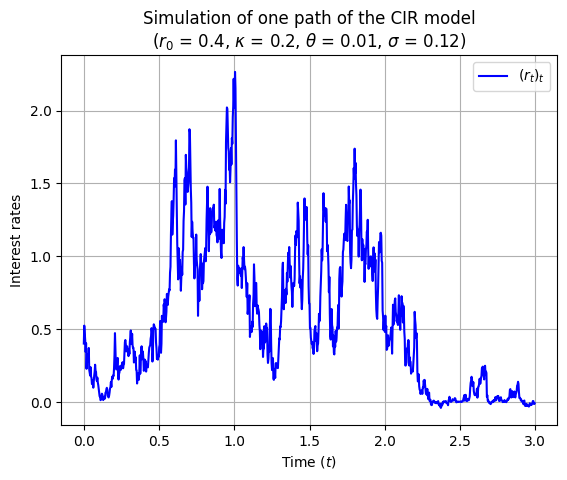

In [13]:
#CIR model
model=CIR(0.4, 0.20, 0.01, 0.12)

#r0 (float): Initial value $r_0$ of the process $(r_t)_t$ at time $t = 0$
#kappa (float): Mean-reversion speed parameter $\kappa$s
#theta (float): Mean-reversion center parameter $\theta$
#sigma (float): Volatility (constant) parameter $\sigma$

# Casting the results into a pandas DataFrame
df = Utils.cast_df(model.simulate_euler(T=3, N = 1000))

# Simulation of a trajectory
_ = df.plot(color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of one path of the CIR model\n{model.get_parameter_string()}")
_ = plt.legend()

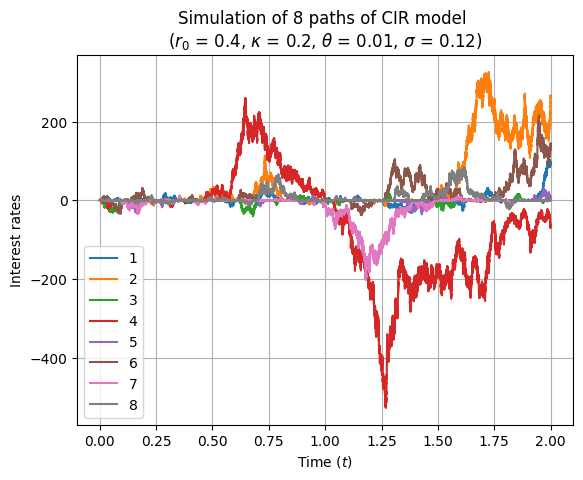

In [14]:
#Now we simulate several trajectories
NB_TRAJECTORIES = 8
_ = Utils.cast_df(model.simulate_paths(NB_TRAJECTORIES, T = 2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of CIR model \n{model.get_parameter_string()}")
_ = plt.legend()

In [15]:
#Now plug it in Black scholes
S0 = 1
sigma = 0.7
rho = 0.5
r =  CIR(0.4, 0.20, 0.01, 0.12)
model = BlackScholes(S0, r, sigma, rho)

d = model.simulate_euler(T=4.2, getRates=True)
df = pd.DataFrame(d)
df.head()

,t,S,r
0,0.000000,1.000000,0.400000
1,0.000042,1.001249,0.400224
2,0.000084,0.999813,0.399771
3,0.000126,0.999466,0.399711
4,0.000168,1.000860,0.399781


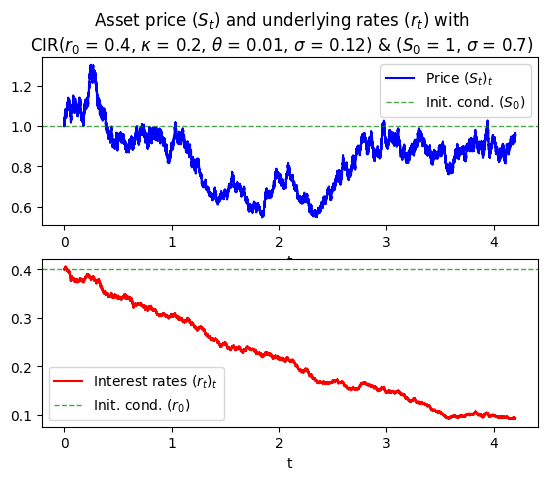

In [16]:
#Plot asset price and interest rates evolution over time 
_, axes = plt.subplots(nrows=2, ncols=1)
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
axes[0].legend()
axes[1].legend()
_ = plt.suptitle(f"Asset price $(S_t)$ and underlying rates $(r_t)$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")

#**Effects of $\kappa$**

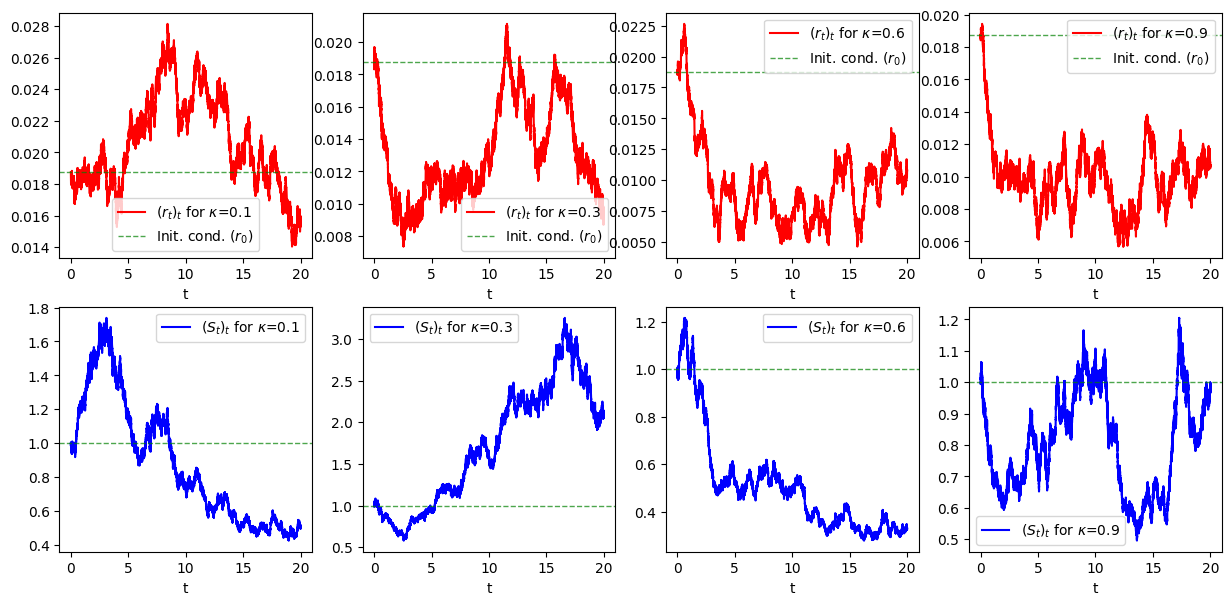

In [17]:
#set a range for kappa 
kappas= [ 0.1,0.3,0.6,0.9 ]
S0 = 1
sigma = 0.7
rho = 0.5

list_data_frame=[]

for kappa in kappas :
    r = Vasicek(0.01875, kappa, 0.01, 0.012) # r0, kappa, theta, sigma
    model = BlackScholes(S0, r, sigma, rho)
    d = model.simulate_euler(T=20, getRates=True)
    df = pd.DataFrame(d)
    list_data_frame.append(df)


_, axes = plt.subplots(nrows=2, ncols=4)



for i in range(len(list_data_frame)):
     _ = list_data_frame[i].plot(x = "t", y = "r", color="red",figsize=(15, 7), label="$(r_t)_t$ for $\kappa$="+ str(kappas[i]) , ax=axes[0][i])
     _ = axes[0][i].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
     axes[0][i].legend()
     _ = list_data_frame[i].plot(x = "t", y = "S", color="blue", label="$(S_t)_t$ for $\kappa$="+ str(kappas[i]), ax=axes[1][i])
     _ = axes[1][i].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")

# **Effects of $\theta$**

(r_t)_t strictly positive
(r_t)_t strictly positive


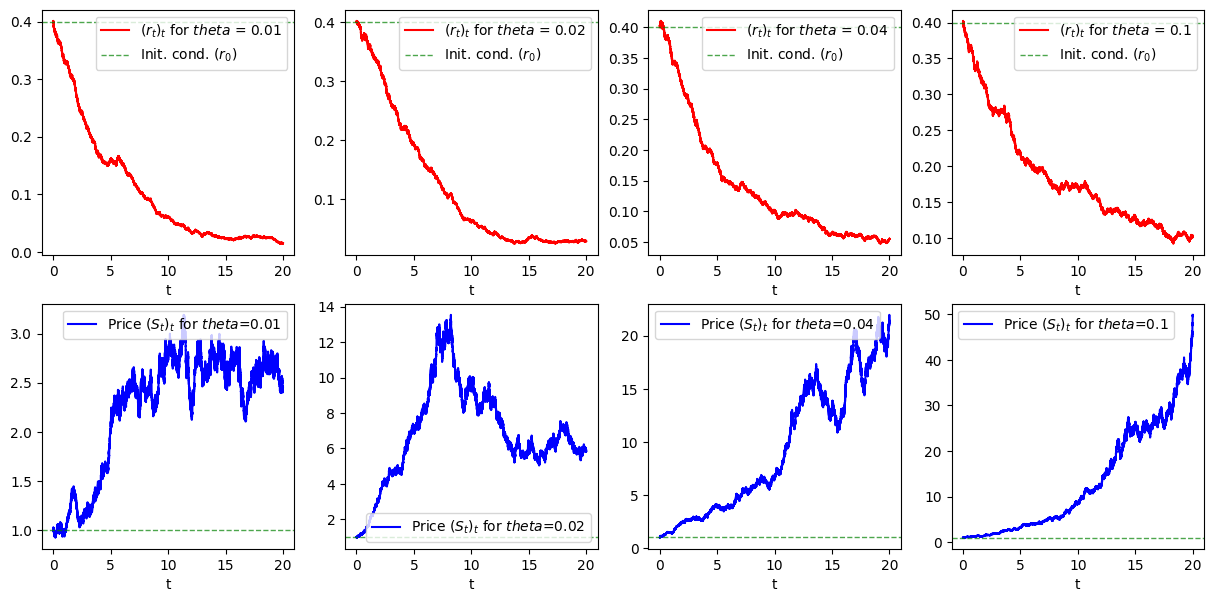

In [18]:
thetas= [ 0.01,0.02,0.04,0.1 ]
S0 = 1
sigma = 0.7
rho = 0.5

list_data_frame=[]

for theta in thetas :
    r = CIR(0.4, 0.20, theta, 0.12)
    model = BlackScholes(S0, r, sigma, rho)
    d = model.simulate_euler(T=20, getRates=True)
    df = pd.DataFrame(d)
    list_data_frame.append(df)

_, axes = plt.subplots(nrows=2, ncols=4)


for i in range(len(list_data_frame)):
     _ = list_data_frame[i].plot(x = "t", y = "r", color="red",figsize=(15, 7), label="$(r_t)_t$ for $theta$ = "+ str(thetas[i]) , ax=axes[0][i])
     _ = axes[0][i].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
     axes[0][i].legend()
     _ = list_data_frame[i].plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$ for $theta$="+ str(thetas[i]), ax=axes[1][i])
     _ = axes[1][i].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")

The CIR model imposes a non-negative constraint on the short rate $r_t$, which is the variable being generated in the loop.
Since the Black-Scholes model in the loop requires the input of the short rate $r_t$ generated by the CIR model, the resulting simulated stock price process will also be strictly positive. Therefore, the output $(r_t)_t$ and the simulated stock price process are strictly positive.





# **Effects of $\rho$**

Text(0.5, 0.98, 'Black-Scholes Model Simulations')

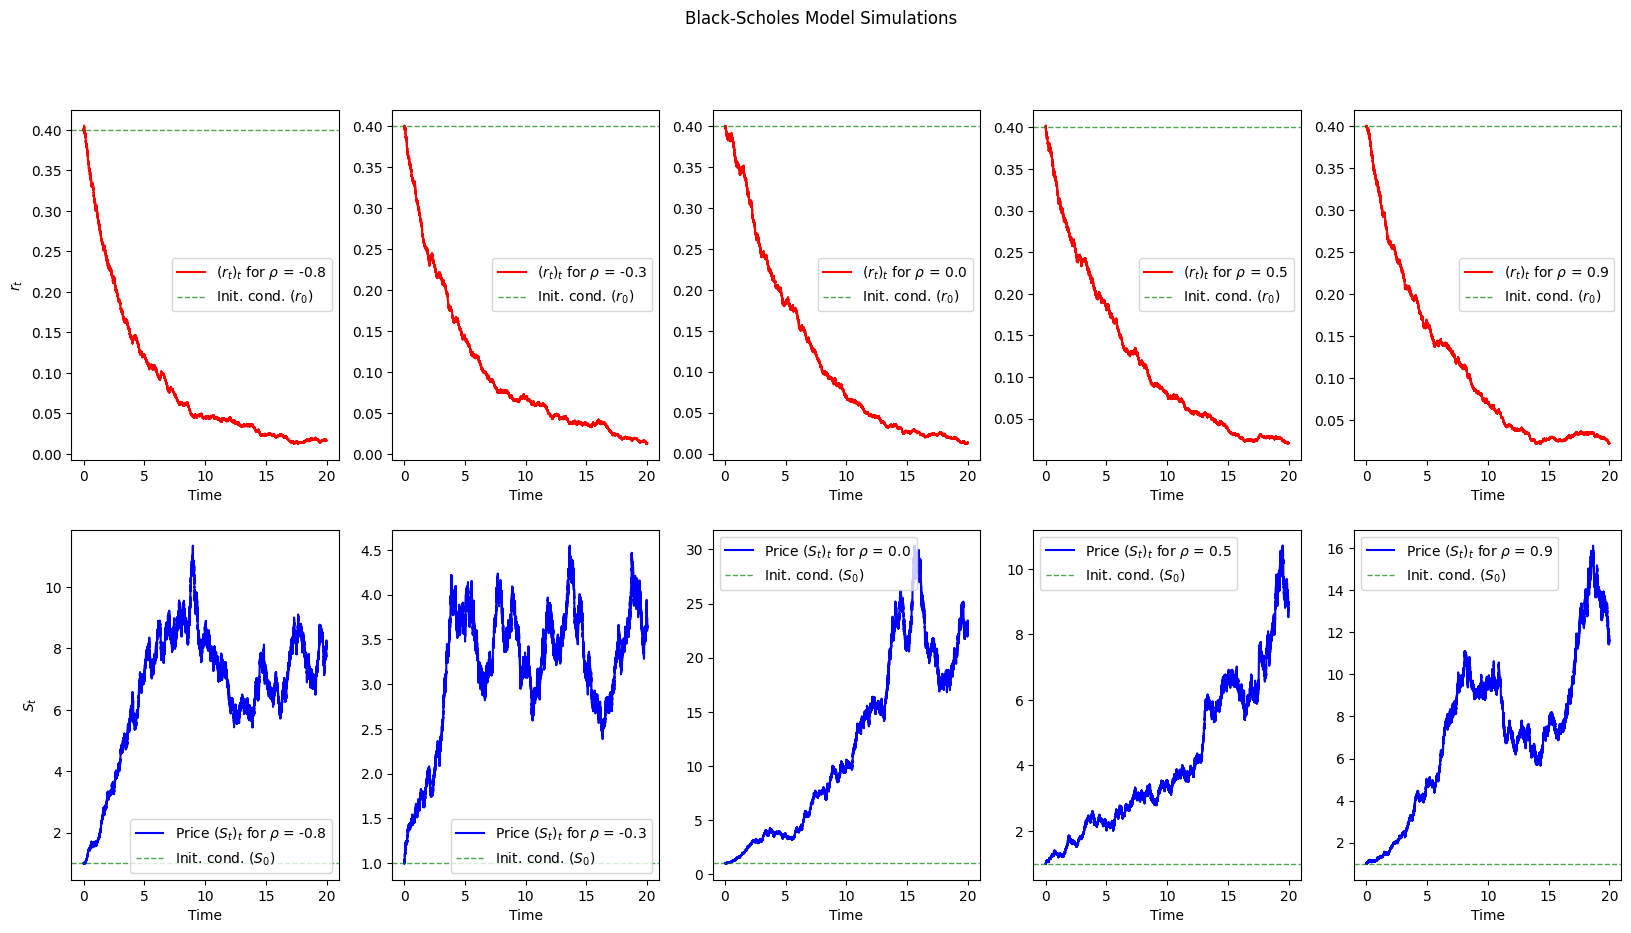

In [19]:
S0 = 1
sigma = 0.7
rhos = [-0.8, -0.3, 0, 0.5, 0.9]

# Create list of data frames
list_data_frame = []
for rho in rhos:
    r = CIR(0.4, 0.20, 0.01, 0.12)
    model = BlackScholes(S0, r, sigma, rho)
    d = model.simulate_euler(T=20, getRates=True)
    df = pd.DataFrame(d)
    list_data_frame.append(df)

# Create subplots and plot data frames
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for i, df in enumerate(list_data_frame):
    df.plot(x="t", y="r", color="red", label="$(r_t)_t$ for $\\rho$ = {:.1f}".format(rhos[i]), ax=axes[0][i])
    axes[0][i].axhline(y=r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
    axes[0][i].legend()
    df.plot(x="t", y="S", color="blue", label="Price $(S_t)_t$ for $\\rho$ = {:.1f}".format(rhos[i]), ax=axes[1][i])
    axes[1][i].axhline(y=model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
    axes[1][i].legend()

# Set axis labels and titles
for ax in axes.flatten():
    ax.set_xlabel("Time")
axes[0, 0].set_ylabel("$r_t$")
axes[1, 0].set_ylabel("$S_t$")
fig.suptitle("Black-Scholes Model Simulations")

## Simulation of the joint distribution $\Big(\int_0^T r_u \mathrm{d}u, S_T\Big) $

In [20]:
from scipy.integrate import trapz

In [21]:
r =  CIR(0.4, 0.20, 0.01, 0.12)
sigma=0.07
model = BlackScholes(S0, r, sigma, rho)

d = model.simulate_euler(T=20, getRates=True)
df = pd.DataFrame(d)

d['r'].cumsum()

d['integrale_r']= (d['r'].cumsum()) * (20/10000)

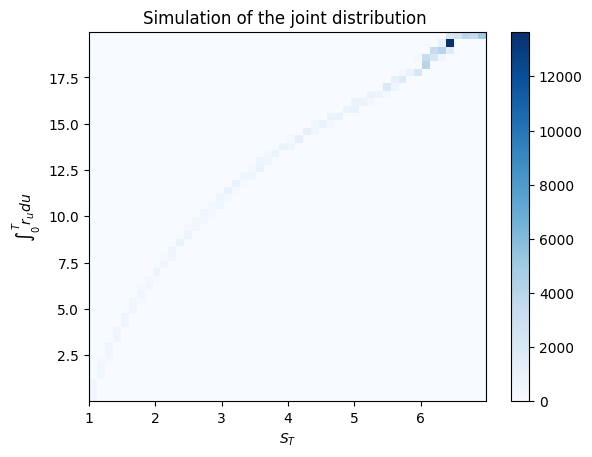

In [23]:
X= d['S']
Y= d['integrale_r']

# Calculate the joint distribution by stacking X and Y as columns in a 2D array
joint_dist = np.column_stack((X, Y))

# Plot the joint distribution
plt.figure()
plt.hist2d(X, Y, bins=50, cmap='Blues')
plt.colorbar()
plt.xlabel('$S_T$')
plt.ylabel('$\int_0^T r_u du $')
plt.title( "Simulation of the joint distribution " )
plt.show()